<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/exercises_notebooks/04_LM_PP_Attachment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PP Attachment 

The Preposition Phrase attachment problem is the difficulty to decide if a preposition in a sentence is attached to a verb or a noun.

In some cases it may even confuse the reader. For example, the sentence:

> San Jose cops kill man with a knife

can be interpreted as either the man or the cops had a knife. The difference in the syntax parsing would be attaching the preposition phrase either to the Verb Phrase ("kill with knife")

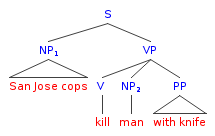

or to the Noun Phrase ("man with knife").

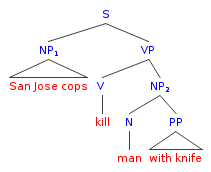


Let's try out the Preposition Phrase attachment classification!

Through this exercise, you'll practice classification of linguistic aspects of text.

# Setup
Loading the data

In [ ]:
import csv

from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from random import choice
from urllib.request import urlopen


In [ ]:
def read_pp_examples(file_url: str) -> List[Dict]:
  """Reads the pp samples from a remtoe url and loads them into a dictionary

  Args:
      file_url (str): a url to load the dataset from

  Returns:
      Dict: a dictionary with two keys: answer and pp
  """
  pp_examples = []
  
  for line in tqdm(urlopen(file_url)):
    line = line.decode("utf-8").strip().split()
    assert(len(line) == 5)
    v,n1,p,n2,answer = line
    pp_examples.append( {'answer':answer,'keywords':(v,n1,p,n2)} )
  return pp_examples

In [ ]:
pp_samples_url = 'https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/pp_examples.txt'

In [ ]:
pp_examples = read_pp_examples(pp_samples_url)


0it [00:00, ?it/s]

# Step #1 - Look at the data

Step 1 is (always) to examine the data!

That means to check the data statistics, load some sample at random and ensure it is correctly labeled, and if possible, plot and visualize the data (histograms, distribution, etc.). 

In [ ]:
print(f"There are {len(pp_examples)} samples in the dataset")

There are 25858 samples in the dataset


In [ ]:
print(choice(pp_examples))

{'answer': 'N', 'keywords': ('sold', 'percent', 'of', 'product')}


Of course, we can reach the dictionary's parts by specifying the key in a squared brackets. 

In [ ]:
random_example = choice(pp_examples)
random_example['keywords']

('leave', 'shareholders', 'with', 'stake')

In [ ]:
random_example['answer']

'V'

# Step 2: Deciding on the measurement

In [ ]:
# we can split the dataset simply through dividing the list 

amt = int(0.75 * len(pp_examples))
train_examples, test_examples = pp_examples[:amt], pp_examples[amt:]

print(len(train_examples), len(test_examples))

19393 6465


We'll define a classifier evaluator.

Given a set of examples and an evaluator, it returns the accuracy score

In [ ]:
def evaluate_classifier(examples, pp_resolver):
  """evaluate the classifier and returns the accuracy score.

  Args:
      examples (List): a list of {'keywords':(v,n1,p,n2), 'answer':answer }
      pp_resolver (_type_): a model with a classify() function that maps from 
        (v,n1,p,n2) to 'N' / 'V'

  Returns:
      float: The accurcy score of the classifier
  """
  correct = 0.0
  incorrect = 0.0
  for example in examples:
      answer = pp_resolver.classify(example['keywords'])
      if answer == example['answer']:
          correct += 1
      else:
          incorrect += 1
  return correct / (correct + incorrect)


# Classifiers

Let's test it on an extremely naive classifiers:

In [ ]:
class AlwaysSayN:
    """
    This naive clasifier answers always with 'Noun'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'N'


In [ ]:
class AlwaysSayV:
    """
    This naive clasifier answers always with 'Verb'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'V'


In [ ]:
evaluate_classifier(test_examples, AlwaysSayV())

0.4634184068058778

In [ ]:
evaluate_classifier(test_examples, AlwaysSayN())

0.5365815931941222

We can see that saying always 'Noun', leads to an accuracy result of 53%.

---



It also means that our dataset is quite balaneced ;)

We could, instead, have tested which class has the majority and simply select it:

In [ ]:
class MajorityClassResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, testing which class is the majority and saves it as a property.

    Args:
        training_examples (List): A list of dictionary training examples.
    """
    answers = [item['answer'] for item in training_examples]
    num_n = len([a for a in answers if a == 'N'])
    num_v = len([a for a in answers if a == 'V'])
    if num_v > num_n:
        self.answer = 'V'
    else:
        self.answer = 'N'

  def classify(self, pp: Tuple) -> str:
    """classify a 4 keywords tuple as N or V attachment, based on the previously calculated majority class

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    return self.answer


In [ ]:
evaluate_classifier(test_examples, MajorityClassResolver(train_examples))

0.5365815931941222

Or make it a bit more sophisticated by peeking at the training examples:

In [ ]:
class LookupResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, load all the training dataset into the memory and during prediction, return the answer if the keywords match a previously saved one. 

    Args:
        training_examples (List): _description_
    """
    self.answers = {}
    for item in training_examples:
        self.answers[item['keywords']] = item['answer']
    self.backoff = MajorityClassResolver(training_examples)
      
  def classify(self, pp: Tuple) -> str:
    """Classify a 4 keywords tuple as N or V attachment.
     If the tuple was found in the previously stored answers, return it.
     Otherwise, return the majority class.

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    if pp in self.answers:
        return self.answers[pp]
    else:
        return self.backoff.classify(pp)

In [ ]:
# If you want to understand what is stored in the `answers` property, uncomment and run the following line:
# LookupResolver(train_examples).answers

In [ ]:
evaluate_classifier(test_examples, LookupResolver(train_examples))

0.6009280742459396

# Exercise - Your Turn:

Implement a discriminative PP-attachment model, using a classifier of your choice (i.e. - Naive Bayes Classifier https://web.stanford.edu/~jurafsky/slp3/4.pdf, [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), etc.) from a toolkit such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

Possible features for back-off algorithm or ML one:

Single items ​
* Identity of v ​
* Identity of p ​
* Identity of n1 ​
* Identity of n2 ​

Pairs:​
* dentity of (v, p) ​
* Identity of (n1, p) ​
* Identity of (p, n1)​

Triplets:​
* Identity of (v, n1, p)​
* Identity of (v, p, n2) ​
* Identity of (n1, p, n2) ​

Quadruple:​
* Identity of (v, n1, p, n2)​


Corpus Level:​

* Have we seen the (v, p) pair in a 5-word window in a big corpus?​
* Have we seen the (n1, p) pair in a 5-word window in a big corpus? ​
* Have we seen the (n1, p, n2) triplet in a 5-word window in a big corpus?​
*  Also: we can use counts, or binned counts.​
* You can use a bigger corpus for additional training purposes as well.

Distance:​
* Distance (in words) between v and p ​
* Distance (in words) between n1 and p​

For the corpus level features, you can simply load one of the english corpuses in NLTK (such as [brown - but don't forget to download it first](https://www.nltk.org/book/ch02.html)). If you use a tagged corpus - such that the words are tagged by their parts of speech, you can create more interesting linguistic-related features.

You can also consider using [WordNet](https://wordnet.princeton.edu/), a large *lexical* database of English words, which is also [implemented in NLTK](https://www.nltk.org/howto/wordnet.html). 

Finally, if you need inspiration and ideas, here are some selected papers:
- [An Analysis of Prepositional-Phrase Attachment Disambiguation](http://ejournals.asia/stj1/ijclr2.pdf) - an overview of different papers dealing with this problem using different methods (kNN, SVN, etc.).
- [The spy saw a cop with a telescope: Who has the telescope?](https://www.semanticscholar.org/paper/The-spy-saw-a-cop-with-a-telescope%3A-Who-has-the-Yan-Nguyen/3220ad0619b72404cb9b1acb9e093a8a564f0f4e) - An linguistic analysis of the potentials reasons (and features) to disambiguify pp attachment. 
- [PREPOSITIONAL PHRASE ATTACHMENT AMBIGUITY RESOLUTION USING SEMANTIC HIERARCHIES](https://eprints.mdx.ac.uk/2471/1/ppattachhier.pdf)
- [Corpus Based PP Attachment Ambiguity Resolution with a Semantic Dictionary](https://aclanthology.org/W97-0109.pdf)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

class NaiveBayesClassifier():
  
  def __init__(self, training_examples: List):
    self.classifier = MultinomialNB()
    
  def classify(self, keywords: Tuple):
    pass

In [ ]:
evaluate_classifier(test_examples, NaiveBayesClassifier(train_examples))

0.0